In [114]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [115]:
%matplotlib inline

# PART I: Regression analysis of the Franke Function

<ipython-input-116-50ed99999a8c>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


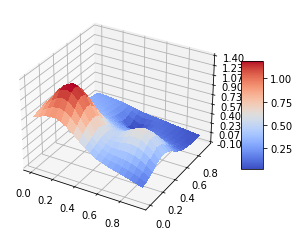

In [116]:
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y)
# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [117]:
class FrankeFunctionData:
    
    def __init__(self, npoints = 101, sigma = 1):
        self.x =  np.linspace(0, 1, npoints)
        self.y =  np.linspace(0, 1, npoints)
        self.XX, self.YY = np.meshgrid(self.x,self.y)
        self.x_obs = self.XX.reshape(-1)
        self.y_obs = self.YY.reshape(-1) 
        
        self.X = np.c_[self.x_obs, self.y_obs]
        self.z = FrankeFunction(self.x_obs, self.y_obs) + 0.01*np.random.normal(0,sigma, self.x_obs.shape)
        
    def __call__(self, degree):
        poly = PolynomialFeatures(degree = degree)
        X_pol = poly.fit_transform(self.X)
        sc = Normalizer().fit(X_pol)
        X_norm = sc.transform(X_pol)
        
        return X_norm, self.z

In [118]:
class Regressor:
    
    def __init__(self,regressor, X_train, X_test, z_train, z_test, lambd = 0):
        self.X_train = X_train
        self.X_test = X_test
        self.z_train = z_train
        self.z_test = z_test
        self.lambd = lambd
        
        if(regressor == 'OLS'):
            self.beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
        elif(regressor == 'Ridge'):
            self.beta = np.linalg.inv(X_train.T.dot(X_train)+lambd*np.identity(X_train.shape[1])).dot(X_train.T).dot(z_train)
        else:
            raise Exception("Only OLS or Ridge are valid inputs for regressor")
        self.z_pred_train = X_train.dot(self.beta)
        self.z_pred_test = X_test.dot(self.beta)
        
    def MSE_train(self):
        return  mean_squared_error(self.z_train, self.z_pred_train)
    
    def MSE_test(self):
        return  mean_squared_error(self.z_test, self.z_pred_test)
    
    def r2score_train(self):
        return  r2_score(self.z_train, self.z_pred_train)
    
    def r2score_test(self):
        return  r2_score(self.z_test, self.z_pred_test)
    
    def covariance_beta(self,sigma=1):
        if(regressor == 'OLS'):
            return sigma**2*np.linalg.inv(X_train.T.dot(X_train))
        elif(regressor == 'Ridge'):
            return sigma**2*np.linalg.inv(X_train.T.dot(X_train)+lambd*np.identity(X_train.shape[1])) 

In [119]:
def Franke_Regression(regressor,degree,lambd = 0):
    data = FrankeFunctionData()
    X, z = data(degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z, train_size=0.66)
    Reg = Regressor(regressor,X_train,X_test,z_train,z_test)
    
    return Reg.MSE_train(), Reg.MSE_test(), Reg.r2score_train(), Reg.r2score_test()
    

## a) Ordinary Least Squares method

#### First OLS regressor without resampling, pol = 5:

In [120]:
Ols5 = Franke_Regression("OLS",5)
print("MSE (train):", Ols5[0])
print("R2 score (train):", Ols5[2])   
print("MSE (test):", Ols5[1])
print("R2 score (test):", Ols5[3]) 

MSE (train): 0.0018304481562328922
R2 score (train): 0.9778806333100394
MSE (test): 0.0020316760483935106
R2 score (test): 0.975211124931919


#### Bias-variance trade-off analysis:

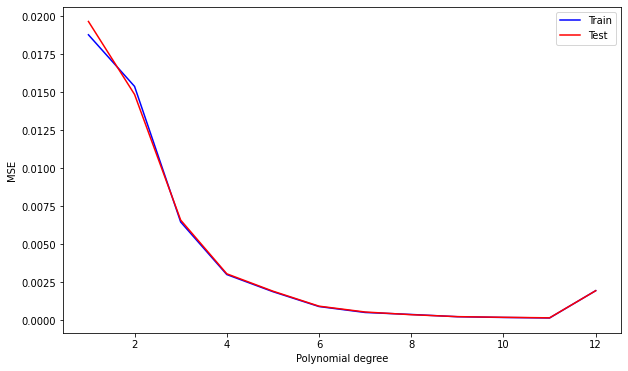

In [121]:
pol = 12
MSE_tests = np.zeros(pol)
MSE_trains = np.zeros(pol)
for i in range(1,pol+1):
    Ols = Franke_Regression("OLS",i)
    MSE_trains[i-1] = Ols[0]
    MSE_tests[i-1] =Ols[1]

    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1,pol+1),MSE_trains, color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_tests, color = 'red', label = 'Test')
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### Bootstrap resampling

In [122]:
n_bootstrap = 20

MSE_tests_bootstrap = np.zeros(n_bootstrap)
MSE_trains_bootstrap = np.zeros(n_bootstrap)
r2_tests_bootstrap = np.zeros(n_bootstrap)
r2_trains_bootstrap = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    Ols = Franke_Regression("OLS",11)
    MSE_trains_bootstrap[i] = Ols[0]
    r2_trains_bootstrap[i] = Ols[2]
    MSE_tests_bootstrap[i] = Ols[1]
    r2_tests_bootstrap[i] = Ols[3]

MSE_bootstrap = np.mean(MSE_tests_bootstrap)
r2_bootstrap = np.mean(r2_tests_bootstrap)

In [123]:
print("MSE (bootstrap):", MSE_bootstrap)
print("R2 score (bootstrap):", r2_bootstrap)   

MSE (bootstrap): 0.0001492582446181583
R2 score (bootstrap): 0.9981919416041432


##### $k$-fold Cross-validation

In [124]:
folds = 5
kf = KFold(n_splits=folds,shuffle=True)

MSE_tests_kfold = np.zeros(folds)
MSE_trains_kfold = np.zeros(folds)
r2_tests_kfold = np.zeros(folds)
r2_trains_kfold = np.zeros(folds)

data = FrankeFunctionData()
X_cv, z_cv = data(11)
itr = 0

for train_i, test_i in kf.split(X_cv):
    X_train, X_test, z_train, z_test = X_cv[train_i], X_cv[test_i], z_cv[train_i], z_cv[test_i]
    OLS = Regressor("OLS",X_train,X_test,z_train,z_test)
    MSE_tests_kfold[itr] = OLS.MSE_test()
    MSE_trains_kfold[itr] = OLS.MSE_train()
    r2_tests_kfold[itr] = OLS.r2score_test()
    r2_trains_kfold[itr] = OLS.r2score_train()
    itr +=1

MSE_kfold = np.mean(MSE_tests_kfold)
r2_kfold = np.mean(r2_tests_kfold)

In [125]:
print("MSE (kfold):", MSE_kfold)
print("R2 score (kfold):", r2_kfold)   

MSE (kfold): 0.00014585299882361144
R2 score (kfold): 0.9982251225426326


## b) Ridge Regression

In [126]:
lambd = np.logspace(-8, 2, 11)

#### Bootstrap resampling

In [127]:
n_bootstraps=20

Ridge_MSE_bootstrap = np.zeros((n_bootstraps,len(lambd)))
Ridge_r2_bootstrap = np.zeros((n_bootstraps,len(lambd)))

for i, l in enumerate(lambd):
    for j in range(n_bootstraps):
        Ridge = Franke_Regression("Ridge",11,l)
        Ridge_MSE_bootstrap[j,i] = Ridge[1]
        Ridge_r2_bootstrap[j,i] = Ridge[3]
        
Lambdas_MSE_bootstrap = np.mean(Ridge_MSE_bootstrap,axis=0)
Lambdas_r2_bootstrap = np.mean(Ridge_r2_bootstrap,axis=0)

#### $k$-fold Cross-validation

In [128]:
folds = 5
kf = KFold(n_splits=folds,shuffle=True)

Ridge_MSE_kfold = np.zeros((folds,len(lambd)))
Ridge_r2_kfold = np.zeros((folds,len(lambd)))

data = FrankeFunctionData()
X_cv, z_cv = data(11)
itr = 0

for train_i, test_i in kf.split(X_cv):
    X_train, X_test, z_train, z_test = X_cv[train_i], X_cv[test_i], z_cv[train_i], z_cv[test_i]
    for i, l in enumerate(lambd):
        Ridge = Regressor("Ridge",X_train,X_test,z_train,z_test,l)
        Ridge_MSE_kfold[itr,i] = Ridge.MSE_test()
        Ridge_r2_kfold[itr,i] = Ridge.r2score_test()
    itr +=1

Lambdas_MSE_kfold = np.mean(Ridge_MSE_kfold,axis=0)
Lambdas_r2_kfold = np.mean(Ridge_r2_kfold,axis=0)

In [129]:
Lambdas_MSE_kfold

array([0.00022635, 0.00027516, 0.00035555, 0.00052753, 0.00085354,
       0.00123404, 0.00180393, 0.00330717, 0.00610015, 0.01078811,
       0.01825829])

#### Bias-Variance trade-off with respect to $\lambda$

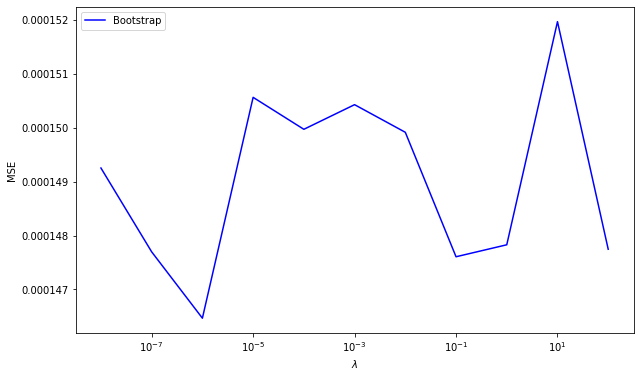

In [130]:
fig2, ax2 =  plt.subplots(figsize=(10,6))
ax2.plot(lambd,Lambdas_MSE_bootstrap, color = 'blue', label = 'Bootstrap')
#ax2.plot(lambd,Lambdas_MSE_kfold, color = 'red', label = 'Cross-Validation')
ax2.set_xlabel('$\lambda$')
ax2.set_ylabel('MSE')
ax2.legend()
ax2.set_xscale('log')
plt.show()

In [131]:
optimal_mse_bootstrap = np.min(Lambdas_MSE_bootstrap)
optimal_r2_bootstrap = Lambdas_r2_bootstrap[np.where(Lambdas_MSE_bootstrap == optimal_mse_bootstrap)][0]
optimal_lambda_bootstrap = lambd[np.where(Lambdas_MSE_bootstrap == optimal_mse_bootstrap)][0]
optimal_mse_kfold = np.min(Lambdas_MSE_kfold)
optimal_r2_kfold = Lambdas_r2_kfold[np.where(Lambdas_MSE_kfold == optimal_mse_kfold)][0]
optimal_lambda_kfold = lambd[np.where(Lambdas_MSE_kfold == optimal_mse_kfold)][0]

print(f"Optimal Bootstrap (lambda = {optimal_lambda_bootstrap}): MSE = {optimal_mse_bootstrap}, r2_score = {optimal_r2_bootstrap}")
print(f"Optimal Cross-Validation (lambda = {optimal_lambda_kfold}): MSE = {optimal_mse_kfold}, r2_score = {optimal_r2_kfold}")

Optimal Bootstrap (lambda = 1e-06): MSE = 0.00014646835048343404, r2_score = 0.9982294345139839
Optimal Cross-Validation (lambda = 1e-08): MSE = 0.00022635495713057917, r2_score = 0.9972519264099322
